In [ ]:
# Install necessary library for handling satellite images
!pip install tifffile

import os
import sys
import psutil
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Path to your specific file
FILE_PATH = '/content/drive/MyDrive/Satellite_Data/GF2_PMS1__L1A0001821711-MSS1.tif'

# Simulation Parameters
PATCH_SIZE = 256
BATCH_SIZE = 8  # A typical batch size for training

print("Environment Ready.")
print(f"Targeting File: {FILE_PATH}")

Mounted at /content/drive
Environment Ready.
Targeting File: /content/drive/MyDrive/Satellite_Data/GF2_PMS1__L1A0001821711-MSS1.tif


In [ ]:
# Check if file exists
if not os.path.exists(FILE_PATH):
    print(f"ERROR: File not found at {FILE_PATH}")
    print("Please check the path or upload the file to your Google Drive.")
else:
    # Load the image
    # Note: Satellite images are often (Channels, Height, Width) or (H, W, C)
    # We load it and standardise to (Height, Width, Channels) for calculation
    large_image = tiff.imread(FILE_PATH)

    # Check dimensionality and transpose if necessary to (H, W, C)
    if large_image.shape[0] < 20: # Likely (Channels, H, W)
        large_image = np.transpose(large_image, (1, 2, 0))

    print(f"Successfully loaded image.")
    print(f"Dimensions: {large_image.shape} (Height, Width, Channels)")
    print(f"Data Type: {large_image.dtype}")

Successfully loaded image.
Dimensions: (6908, 7300, 4) (Height, Width, Channels)
Data Type: uint8


In [ ]:
def calculate_memory_stress(image, batch_size):
    """
    Calculates the theoretical memory required to pass a full image
    through a standard U-Net with gradients.
    """
    h, w, c = image.shape

    # 1. Raw Input Size (Float32)
    # 4 bytes per pixel * H * W * C
    num_pixels = h * w * c
    raw_size_bytes = num_pixels * 4 # 32-bit float
    raw_size_gb = raw_size_bytes / (1024**3)

    # 2. Deep Learning Overhead (The "Hidden" Cost)
    # A U-Net stores feature maps at every layer for backpropagation.
    # A safe rule of thumb is ~4x to 6x the input size per image in a batch.
    # Plus, we need memory for the Model Weights and the Optimizer State.
    DL_OVERHEAD_FACTOR = 6

    # Total VRAM needed for ONE batch
    vram_needed_gb = raw_size_gb * DL_OVERHEAD_FACTOR * batch_size

    # Check available system RAM (Colab usually gives ~12GB or ~25GB)
    total_ram = psutil.virtual_memory().total / (1024**3)

    print(f"--- MEMORY STRESS ANALYSIS ---")
    print(f"1. Single Raw Image Size: {raw_size_gb:.2f} GB")
    print(f"2. Batch Size for Training: {batch_size}")
    print(f"3. Theoretical VRAM Required: {vram_needed_gb:.2f} GB")
    print(f"4. Available System RAM:      {total_ram:.2f} GB")

    print("\n--- CONCLUSION ---")
    if vram_needed_gb > total_ram:
        print(f"❌ CRITICAL FAIL: Training requires {vram_needed_gb:.2f} GB, but you only have {total_ram:.2f} GB.")
        print("   ATTEMPTING TO TRAIN ON RAW IMAGE WILL CRASH THE KERNEL.")
        print("   SOLUTION: Image slicing is MANDATORY.")
    else:
        print("   Memory is sufficient (Unlikely for large satellite images).")

# Run the stress test
calculate_memory_stress(large_image, BATCH_SIZE)

--- MEMORY STRESS ANALYSIS ---
1. Single Raw Image Size: 0.75 GB
2. Batch Size for Training: 8
3. Theoretical VRAM Required: 36.07 GB
4. Available System RAM:      12.67 GB

--- CONCLUSION ---
❌ CRITICAL FAIL: Training requires 36.07 GB, but you only have 12.67 GB.
   ATTEMPTING TO TRAIN ON RAW IMAGE WILL CRASH THE KERNEL.
   SOLUTION: Image slicing is MANDATORY.


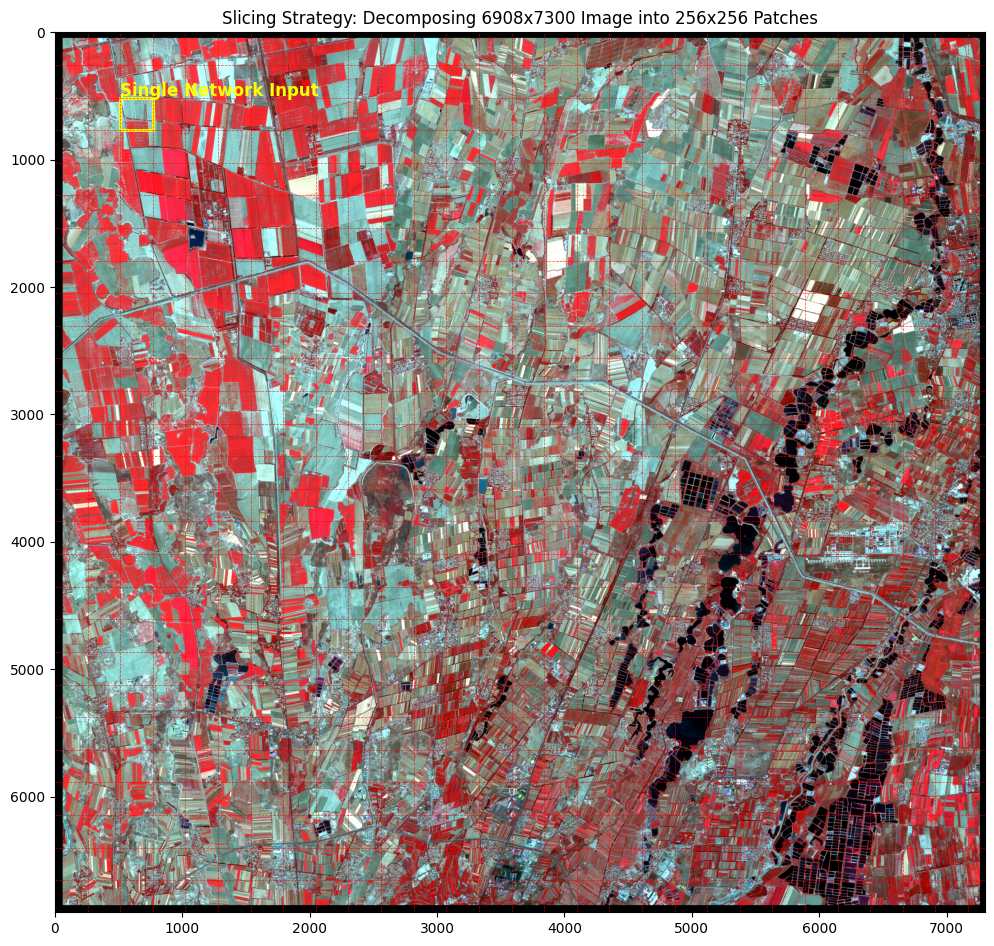

In [ ]:
def plot_visual_grid(image, patch_size=256):
    """
    Visualizes the slicing strategy by overlaying a grid on the full image.
    """
    h, w, c = image.shape

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Display the image (use only first 3 channels for RGB display)
    # We verify if normalization is needed for display
    display_img = image[:, :, :3].astype('float32')
    if display_img.max() > 255:
        display_img /= 65535.0  # Normalize 16-bit
    elif display_img.max() > 1.0:
        display_img /= 255.0    # Normalize 8-bit

    ax.imshow(display_img)
    ax.set_title(f"Slicing Strategy: Decomposing {h}x{w} Image into {patch_size}x{patch_size} Patches")

    # --- Draw the Grid ---
    # We draw lines to represent the cuts
    # Vertical Lines
    for x in range(0, w, patch_size):
        ax.axvline(x, color='red', linestyle='--', linewidth=0.5, alpha=0.7)

    # Horizontal Lines
    for y in range(0, h, patch_size):
        ax.axhline(y, color='red', linestyle='--', linewidth=0.5, alpha=0.7)

    # --- Highlight One Patch ---
    # Let's highlight a random patch to show "Input Size"
    rect = patches.Rectangle((512, 512), patch_size, patch_size, linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)
    ax.text(512, 500, "Single Network Input", color='yellow', fontsize=12, fontweight='bold')

    plt.show()

# Run the visualization
plot_visual_grid(large_image, PATCH_SIZE)

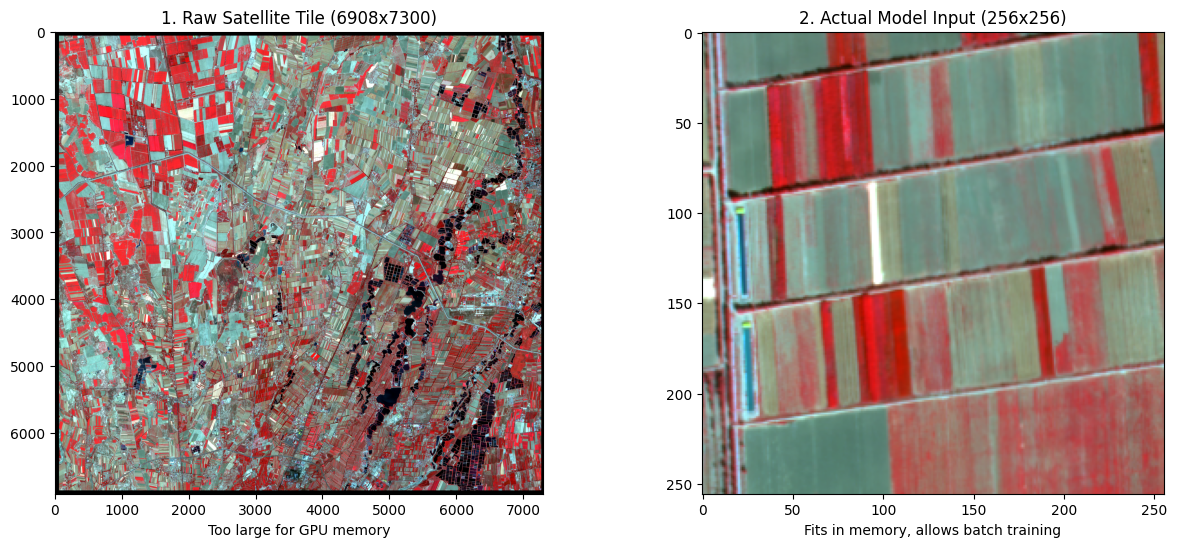

In [ ]:
def show_scale_difference(image, patch_size=256):
    h, w, c = image.shape

    # Extract one real patch from the center
    center_y = h // 2
    center_x = w // 2
    patch = image[center_y:center_y+patch_size, center_x:center_x+patch_size, :3]

    # Normalize for display
    patch = patch.astype('float32')
    if patch.max() > 255: patch /= 65535.0
    else: patch /= 255.0

    full_thumb = image[:, :, :3].astype('float32')
    if full_thumb.max() > 255: full_thumb /= 65535.0
    else: full_thumb /= 255.0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Full Map
    ax1.imshow(full_thumb)
    ax1.set_title(f"1. Raw Satellite Tile ({h}x{w})")
    ax1.set_xlabel("Too large for GPU memory")

    # Plot 2: Single Patch
    ax2.imshow(patch)
    ax2.set_title(f"2. Actual Model Input ({patch_size}x{patch_size})")
    ax2.set_xlabel("Fits in memory, allows batch training")

    plt.show()

show_scale_difference(large_image, PATCH_SIZE)

--- SLIDING WINDOW LOGIC ---
1. Red boxes show standard non-overlapping cuts.
2. The Yellow line is a 'Danger Zone' where the model loses context.
3. The Cyan (Dashed) box sits right on top of that danger zone.
4. Result: Every pixel is predicted multiple times, removing edge errors.


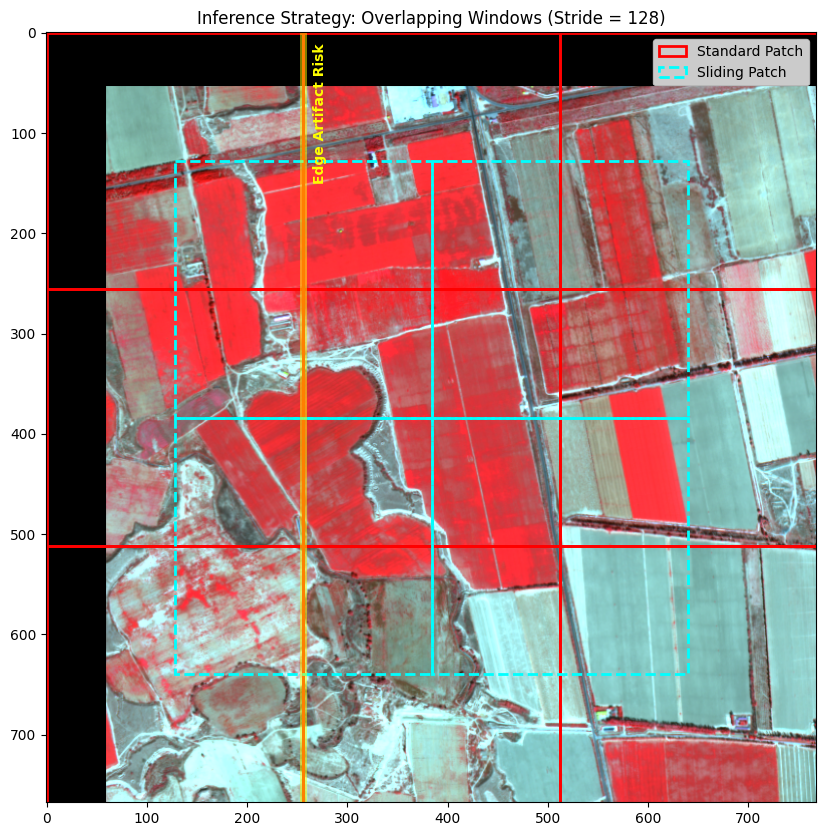

In [ ]:
def visualize_sliding_window_strategy(image, patch_size=256):
    """
    Demonstrates why we use overlapping windows during inference.
    Red Boxes = Standard Grid (Edges are vulnerable)
    Cyan Boxes = Sliding Window (Covers the edges of the Standard Grid)
    """
    # Zoom in on a specific section to make the diagram readable
    # We look at a 3x3 patch area (approx 768x768 pixels)
    zoom_size = patch_size * 3
    zoom_img = image[:zoom_size, :zoom_size, :3].astype('float32')

    # Normalize for display
    if zoom_img.max() > 255: zoom_img /= 65535.0
    else: zoom_img /= 255.0

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(zoom_img)
    ax.set_title(f"Inference Strategy: Overlapping Windows (Stride = {patch_size//2})")

    # 1. Draw STANDARD Grid (Red)
    # These represent the hard cuts. The model is weak at these red lines.
    for y in range(0, zoom_size, patch_size):
        for x in range(0, zoom_size, patch_size):
            rect = patches.Rectangle((x, y), patch_size, patch_size,
                                     linewidth=2, edgecolor='red', facecolor='none', label='Standard Patch')
            ax.add_patch(rect)

    # 2. Draw SLIDING Grid (Cyan)
    # These are shifted by half a patch size. They cover the red lines!
    stride = patch_size // 2
    for y in range(stride, zoom_size - stride, patch_size):
        for x in range(stride, zoom_size - stride, patch_size):
            rect = patches.Rectangle((x, y), patch_size, patch_size,
                                     linewidth=2, edgecolor='cyan', linestyle='--', facecolor='none', label='Sliding Patch')
            ax.add_patch(rect)

    # 3. Highlight the "Danger Zone"
    # Show how a Cyan box sits directly on top of a Red boundary
    # We highlight the boundary at x=256
    ax.axvline(patch_size, color='yellow', linewidth=5, alpha=0.5)
    ax.text(patch_size + 10, stride + 20, "Edge Artifact Risk", color='yellow', fontsize=10, fontweight='bold', rotation=90)

    # Add a legend (handling duplicate labels)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    print("--- SLIDING WINDOW LOGIC ---")
    print("1. Red boxes show standard non-overlapping cuts.")
    print("2. The Yellow line is a 'Danger Zone' where the model loses context.")
    print("3. The Cyan (Dashed) box sits right on top of that danger zone.")
    print("4. Result: Every pixel is predicted multiple times, removing edge errors.")

    plt.show()

# Run the visualization
visualize_sliding_window_strategy(large_image, PATCH_SIZE)